<h2 style="font-weight:700;">ЛАБОРАТОРНАЯ РАБОТА №6</h2>

<p style="font-weight:600;">РЕШЕНИЕ ЗАДАЧИ КЛАСИФИКАЦИИ МЕТОДОМ РЕШАЮЩИХ ДЕРЕВЬЕВ</p>

<p style="font-weight:600">Цели и задачи работы</p>

<p><span style="font-weight:600;">Цель лабораторной работы:</span> научиться решать задачу классификации методами
решающих деревьев и ансамблей на их основе.<p>
<span style="font-weight:600;">Основные задачи:</span>
<ul>
<li>освоить метод Random Forest (Случайный лес) – алгоритма машинного
обучения, относящегося к классу ансамблевых методов;</li>
<li>оценить эффективность алгоритма на практическом примере;</li>
<li>изучение методов визуализации модели и оценки ее корректности.</li>
</ul>

<p>В своему работе я использую датасет – – blood.csv. Набор данных содержит информацию о донорах и выполненных ими трансфу-
зиях до марта 2007 г. включительно. Целью исследования является построение про-
гноза сдачи донором крови в марте 2007 г. Полученный результат позволяет оценить

вероятность посещения донором центра сдачи крови в дальнейшем и относится к за-
дачам бинарной классификации. В исследовании используется база данных доноров

медицинского центра города Синьчжу на Тайване. Из базы данных медицинского цен-
тра случайным образом были выбраны 748 доноров для анализа.</p>

<p style="font-weght:600;">Атрибуты:</p>
<ul>
<li>Recency – количество месяцев с момента последней сдачи крови донором;</li>
<li>Frequency – общее количество трансфузий донора;</li>
<li>Monetary – количество сданной донором крови в куб. см.;</li>
<li>Time – количество месяцев с момента первого донорства;</li>
<li>Class – целевая переменная прогноза трансфузии.</li>

</ul>

<h2>Импортируем библиотеки и загружаем данные</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

# Для воспроизводимости результатов
np.random.seed(42)
     

In [2]:

# Загружаем набор данных о прогнозировании рака (бинарная классификация)
data = pd.read_csv("blood.csv")
data.head()

,Recency,Frequency,Monetary,Time,Class
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [3]:

data.describe()

,Recency,Frequency,Monetary,Time,Class
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


In [4]:

data.shape

(748, 5)

In [5]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    748 non-null    int64
 1   Frequency  748 non-null    int64
 2   Monetary   748 non-null    int64
 3   Time       748 non-null    int64
 4   Class      748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


<h2>Проверяем данные на наличие пропущенных значений и выбросов</h2>

In [7]:
# проверяем на пропущенные значения
print(data.isnull().sum())

Recency      0
Frequency    0
Monetary     0
Time         0
Class        0
dtype: int64


<h2>Разделяем данные на признаки и целевую переменную</h2>

In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


data_copy = data.copy()
data_copy.head()

y = data_copy['Class']
X = data_copy.drop('Class', axis=1)
X.head()

,Recency,Frequency,Monetary,Time
0,2,50,12500,98
1,0,13,3250,28
2,1,16,4000,35
3,2,20,5000,45
4,1,24,6000,77


<h2>Применяем операцию нормализации для численной устойчивости</h2>

In [10]:
standardizer = StandardScaler()
X_scaled = standardizer.fit_transform(X)

# Сохраняем имена признаков и делаем DataFrame обратно, чтобы потом оценить важность признаков
feature_names = X.columns
X_scaled = pd.DataFrame(X_scaled, columns=feature_names)

X_scaled.head()

,Recency,Frequency,Monetary,Time
0,-0.927899,7.623346,7.623346,2.615633
1,-1.175118,1.282738,1.282738,-0.257881
2,-1.051508,1.796842,1.796842,0.029471
3,-0.927899,2.482313,2.482313,0.439973
4,-1.051508,3.167784,3.167784,1.753579


<h2>Разделение данных на обучающую и тестовую выборки</h2>

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#Разделение данных на обучающую и тестовую выборки (70/30)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print(f"Обучающая выборка: {X_train.shape[0]} samples")
print(f"Тестовая выборка: {X_test.shape[0]} samples")


Обучающая выборка: 523 samples
Тестовая выборка: 225 samples


<h2>Создание и обучение модели Random Forest</h2>

In [14]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Обучаем модель на обучающих данных
rf_model.fit(X_train, y_train)

print("Модель Random Forest обучена!")

Модель Random Forest обучена!


<h2>Прогнозирование и оценка модели</h2>

In [15]:
# Делаем прогнозы на тестовой выборке
y_pred = rf_model.predict(X_test)

# Оцениваем точность модели
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели на тестовой выборке: {accuracy:.4f}")

Точность модели на тестовой выборке: 0.7467


In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Выводим подробный отчет по классификации
target_names = ['No Transfusion', 'Transfusion']
print("\n" + "="*50)
print("Отчет по классификации:")
print("="*50)
print(classification_report(y_test, y_pred, target_names=target_names))


Отчет по классификации:
                precision    recall  f1-score   support

No Transfusion       0.78      0.92      0.84       165
   Transfusion       0.55      0.28      0.37        60

      accuracy                           0.75       225
     macro avg       0.66      0.60      0.61       225
  weighted avg       0.72      0.75      0.72       225



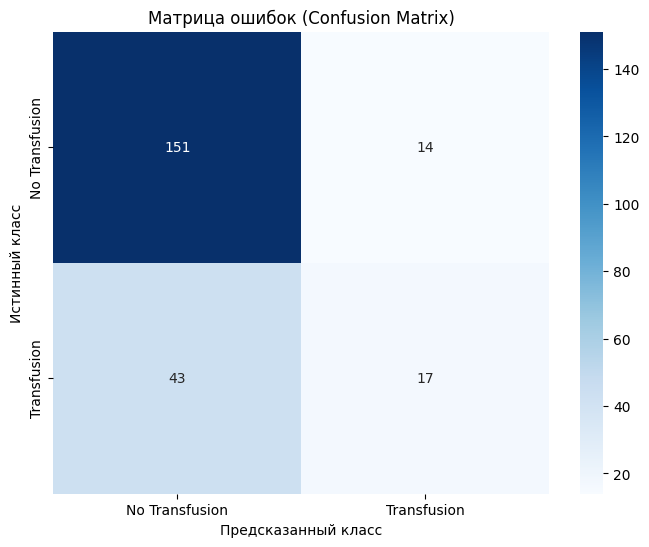

In [17]:
# Строим матрицу ошибок (Confusion Matrix)
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Матрица ошибок (Confusion Matrix)")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.show()

<h2>Анализ важности признаков</h2>

In [18]:
feature_importances = rf_model.feature_importances_
features_df = pd.DataFrame({"feature": X.columns, "importance": feature_importances})
features_df = features_df.sort_values("importance", ascending=False)

# Выводим таблицу с важностью признаков
print(features_df)

     feature  importance
3       Time    0.433516
0    Recency    0.272606
2   Monetary    0.149410
1  Frequency    0.144468


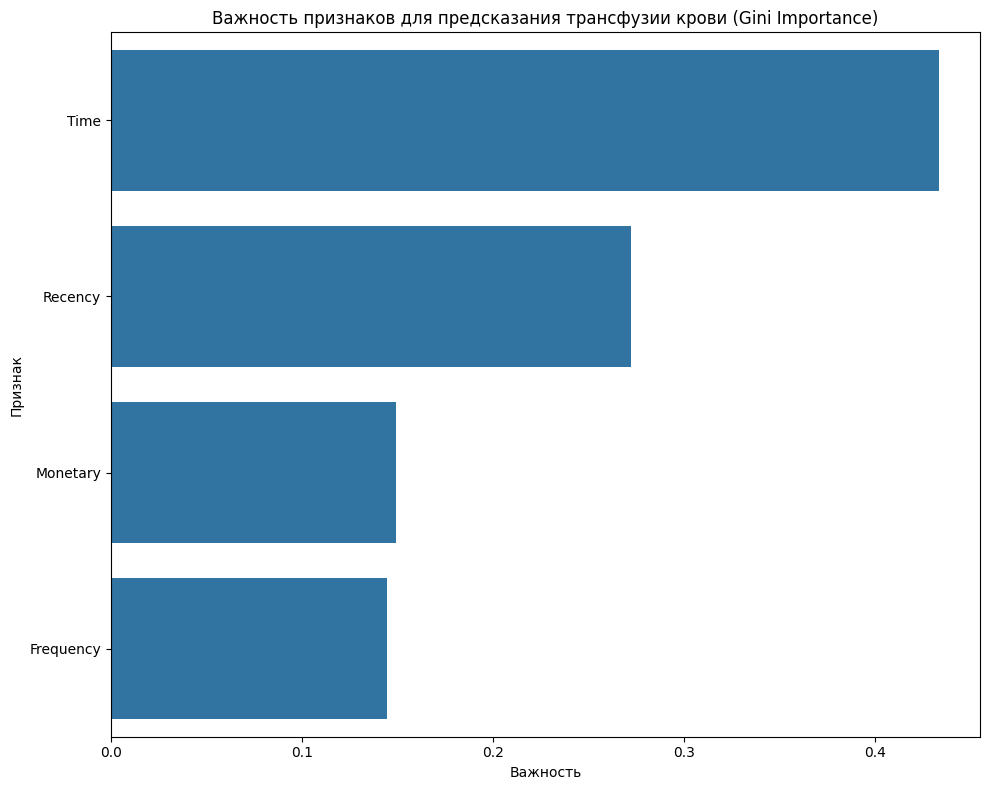

In [19]:
plt.figure(figsize=(10, 8))
sns.barplot(x="importance", y="feature", data=features_df.head(4))
plt.title("Важность признаков для предсказания трансфузии крови (Gini Importance)")
plt.xlabel("Важность")
plt.ylabel("Признак")
plt.tight_layout()
plt.show()

<p>Получаем ранжирование признаков по их влиянию на предсказание Class

Визуализируем топ-4 самых важных признака для Random Forest</p>

In [20]:
# Вывод таблицы с важностью признаков
print("Топ-4 самых важных признаков для предсказания трансфузии крови:")
print(features_df.head(4))


Топ-4 самых важных признаков для предсказания трансфузии крови:
     feature  importance
3       Time    0.433516
0    Recency    0.272606
2   Monetary    0.149410
1  Frequency    0.144468


<h2>Подбор гиперпараметров</h2>

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Определяем сетку параметров для перебора
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Создаем модель Random Forest
rf = RandomForestClassifier(random_state=42)

# Создаем объект GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, scoring="accuracy", n_jobs=-1)

# Запускаем подбор гиперпараметров на обучающих данных
grid_search.fit(X_train, y_train)

# Выводим лучшие параметры
print("Лучшие гиперпараметры для Random Forest:")
print(grid_search.best_params_)


Лучшие гиперпараметры для Random Forest:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}


In [22]:
# Выводим лучшие параметры и точность кросс-валидации
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность при кросс-валидации: {:.4f}".format(grid_search.best_score_))

# Оцениваем лучшую модель на тестовых данных
best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Точность улучшенной модели на тестовой выборке: {best_accuracy:.4f}")

Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Лучшая точность при кросс-валидации: 0.7954
Точность улучшенной модели на тестовой выборке: 0.7378
